In [1]:
import os
import scipy as sp
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

In [2]:
import torch
import torchvision

print("PyTorch version:", torch.__version__)
print("Torchvision version:", torchvision.__version__)
print("CUDA is available:", torch.cuda.is_available())

import numpy as np
import torch
import matplotlib.pyplot as plt
#!pip install opencv-python
import cv2
import sys

#!pip install git+https://github.com/facebookresearch/segment-anything.git

from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor
import os

PyTorch version: 2.1.1
Torchvision version: 0.16.1
CUDA is available: True


In [4]:
img = sp.io.loadmat("../data/Kaggle/Farsiu_Ophthalmology_2013_AMD_Subject_1002.mat")

In [5]:
img['images'].shape

(512, 1000, 100)

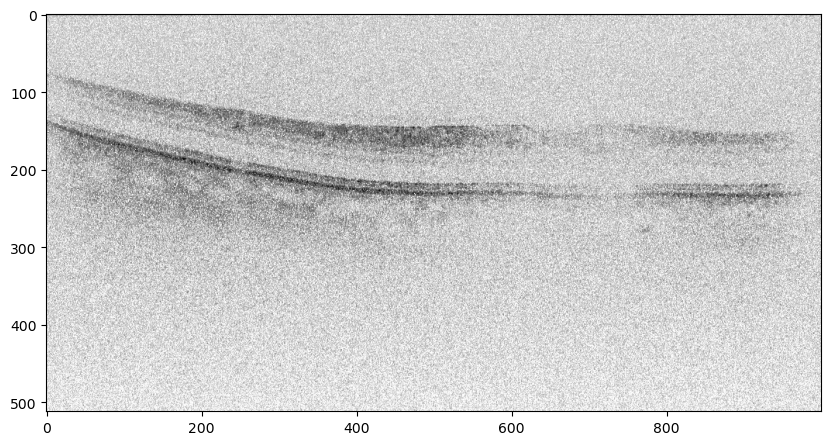

In [10]:
fig = plt.figure(figsize=(10, 10))

def updatefig(i):
    fig.clear()
    plt.imshow(img['images'][:, :, i], cmap="Greys", vmin=0, vmax=255)
    plt.draw()

anim = animation.FuncAnimation(fig, updatefig, 90)
anim.save("../data/Kaggle/Farsiu_0001.mp4", fps=5)

In [9]:
os.getcwd()

'C:\\Users\\phili\\Documents\\DILab\\DILabOCT\\experiments'

In [11]:
sam_checkpoint = "../data/SAM_checkpoint/sam_vit_b_01ec64.pth"
model_type = "vit_b"
device = "cuda"
sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

Sam(
  (image_encoder): ImageEncoderViT(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (blocks): ModuleList(
      (0-11): 12 x Block(
        (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (proj): Linear(in_features=768, out_features=768, bias=True)
        )
        (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Linear(in_features=3072, out_features=768, bias=True)
          (act): GELU(approximate='none')
        )
      )
    )
    (neck): Sequential(
      (0): Conv2d(768, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): LayerNorm2d()
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (3): LayerNorm2d()
    )


In [12]:
mask_generator_ = SamAutomaticMaskGenerator(
    model=sam,
    points_per_side=32,
    pred_iou_thresh=0.9,
    stability_score_thresh=0.96,
    crop_n_layers=1,
    crop_n_points_downscale_factor=2,
    min_mask_region_area=100,  # Requires open-cv to run post-processing
)

In [13]:
colors = ['#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231', '#911eb4', '#46f0f0', '#f032e6', '#bcf60c', '#fabebe', '#008080', '#e6beff', '#9a6324', '#fffac8', '#800000', '#aaffc3', '#808000', '#ffd8b1', '#000075', '#808080']
for i in range(len(colors)):
  h = colors[i].lstrip('#')
  colors[i] = tuple(int(h[i:i+2], 16) for i in (0, 2, 4))
print(colors)

[(230, 25, 75), (60, 180, 75), (255, 225, 25), (67, 99, 216), (245, 130, 49), (145, 30, 180), (70, 240, 240), (240, 50, 230), (188, 246, 12), (250, 190, 190), (0, 128, 128), (230, 190, 255), (154, 99, 36), (255, 250, 200), (128, 0, 0), (170, 255, 195), (128, 128, 0), (255, 216, 177), (0, 0, 117), (128, 128, 128)]


In [14]:
def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)
    polygons = []
    color = []
    for cl, ann in enumerate(sorted_anns):
        m = ann['segmentation']
        img = np.ones((m.shape[0], m.shape[1], 3))
        color_mask = np.random.random((1, 3)).tolist()[0]
        for i in range(3):
            img[:, :, i] = colors[cl][i] / 255
        ax.imshow(np.dstack((img, m * 0.35)))

In [15]:
def transform_image(img):
  image = np.expand_dims(img, axis=2)
  image = np.repeat(255 - image, 3, axis=2)
  return image

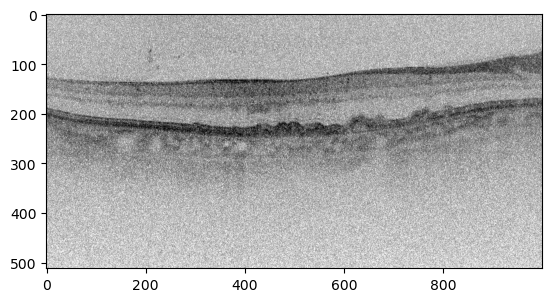

In [16]:
plt.imshow(transform_image(img['images'][:, :, 41]))
plt.show()

In [17]:
transform_image(img['images'][:, :, 41]).shape

(512, 1000, 3)

3


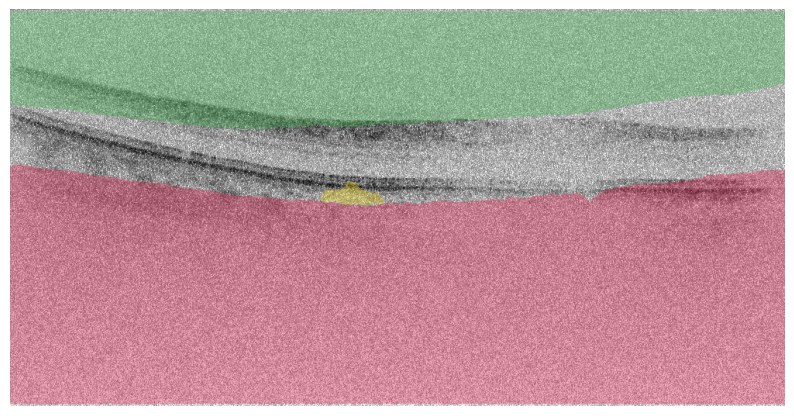

In [18]:
masks = mask_generator_.generate(transform_image(img['images'][:, :, 25]))
print(len(masks))
plt.figure(figsize=(10, 10))
plt.imshow(transform_image(img['images'][:, :, 1]))
show_anns(masks)
plt.axis('off')
plt.show()

In [20]:
masks


[{'segmentation': array([[False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         ...,
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False]]),
  'area': 1484,
  'bbox': [401.0, 223.0, 81.0, 29.0],
  'predicted_iou': 0.9246178865432739,
  'point_coords': [[458.59375, 246.53125]],
  'stability_score': 0.9669312238693237,
  'crop_box': [0.0, 0.0, 587.0, 343.0]},
 {'segmentation': array([[False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         ...,
         [False, False, False, ...,  True,  True,  True],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False]]),
  'area': 277689,
  '

0 3
0 3
1 2
2 2
3 2
4 2
5 3
6 4
7 3
8 2
9 2
10 2
11 3
12 4
13 3
14 5
15 3
16 4
17 3
18 3
19 2
20 2
21 2
22 2
23 2
24 3
25 3
26 2
27 2
28 2
29 2
30 2
31 3
32 2
33 2
34 2
35 2
36 2
37 3
38 3
39 2
0 3


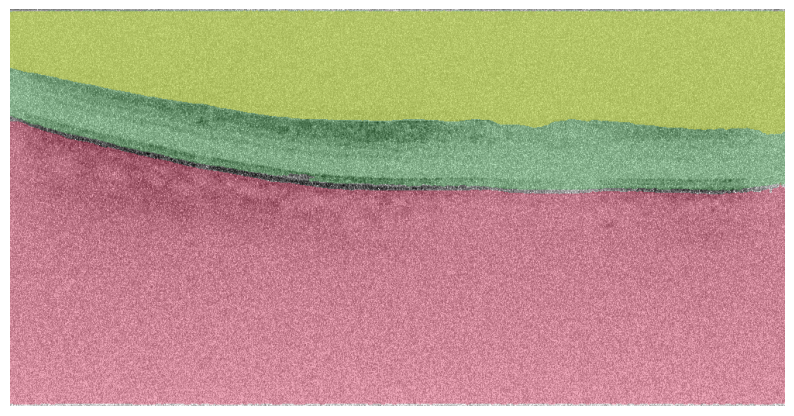

In [19]:
fig = plt.figure(figsize=(10, 10))

def updatefig(i):
    fig.clear()
    try:
      masks = mask_generator_.generate(transform_image(img['images'][:, :, i]))
    except Exception as e:
      print(f"Got exception for frame {i}")
      print(e)
      masks = []
    print(i, len(masks))
    plt.imshow(transform_image(img['images'][:, :, i]))
    show_anns(masks)
    plt.axis('off')
    plt.draw()

anim = animation.FuncAnimation(fig, updatefig, 40)
anim.save("../data/Kaggle/Farsiu_sam_mask_0001.mp4", fps=5)